In [69]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [70]:
def hook_fn (module, input, output):
    global conv_output
    conv_output = output

In [71]:
from resnetCopy1 import ResNet18
net = ResNet18()
checkpoint = torch.load('models/adaptive_patch_cifar10/adaptive_patch_cifar10_0000.pt', map_location='cuda:0')
net.load_state_dict(checkpoint)
net.eval () # 設置為評估模式

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [72]:
conv_layer = net.layer4[1].conv2

In [73]:
handle = conv_layer.register_forward_hook (hook_fn)

In [74]:
import pandas as pd
df = pd.read_csv('new_adp.csv')
data = df.loc[:, df.columns != 'target'].values
target = df['target'].values

# 数据预处理
data = torch.from_numpy(data)
data = data.reshape(-1, 3, 32, 32)
print(data.shape)
target = np.where(target == 'target', 0, target)
target = target.astype(int)
target = torch.from_numpy(target).long()



torch.Size([7999, 3, 32, 32])


/tmp/ipykernel_2329317/3626712235.py:2: DtypeWarning: Columns (3072) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('new_adp.csv')


In [75]:
device = torch.device("cuda")
images = data.to(torch.float)  
labels = target.to(device)

In [76]:
outputs = net (images) 

In [77]:
conv_output.shape

torch.Size([7999, 512, 4, 4])

In [78]:
labels.shape

torch.Size([7999])

In [79]:
n,c,w,h = conv_output.shape

In [80]:
conv_output = conv_output.view (n, -1)

In [81]:
conv_output.shape

torch.Size([7999, 8192])

In [82]:
conv_output = conv_output.cpu().detach().numpy()

In [83]:
tsne = TSNE (n_components=2)
conv_output_2d = tsne.fit_transform (conv_output)

In [84]:
conv_output_2d.shape

(7999, 2)

In [85]:
labels.shape

torch.Size([7999])

In [86]:
label = labels.cpu().numpy()

In [87]:
label[6500:]

array([0, 0, 0, ..., 0, 0, 0])

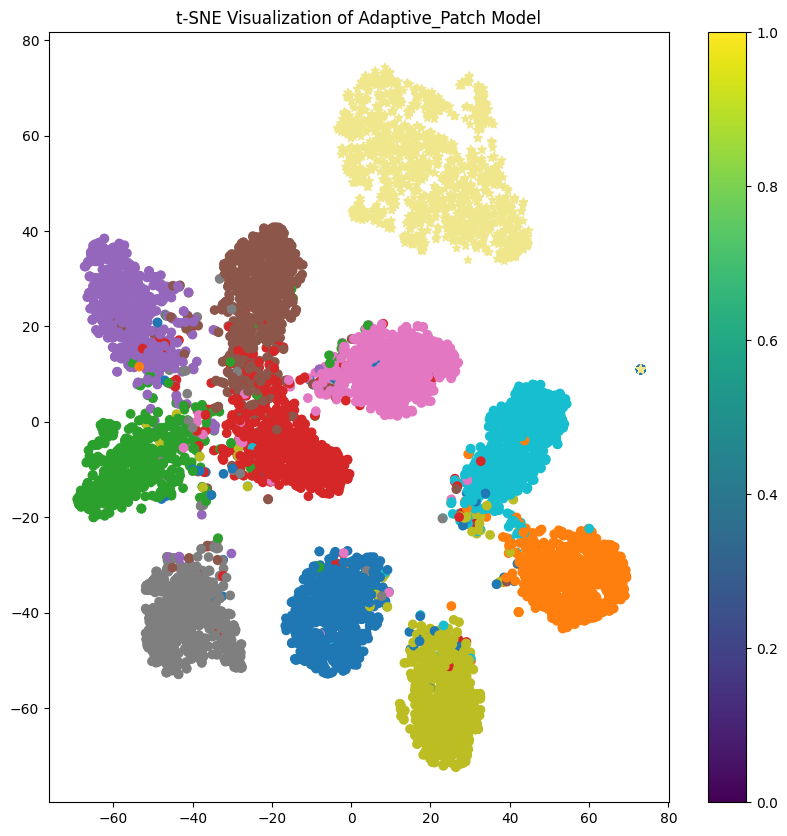

In [88]:
# Plot the scatter plot
plt.figure(figsize=(10, 10))

# Plot the data points before index 6499 (default color)
plt.scatter(conv_output_2d[:6499, 0], conv_output_2d[:6499, 1], c=label[:6499], cmap='tab10')

# Plot the data points from index 6499 onwards (custom shape and color)
custom_colors = ['khaki'] * (conv_output_2d.shape[0] - 6499)
plt.scatter(conv_output_2d[6499:, 0], conv_output_2d[6499:, 1], c=custom_colors, marker='*')


plt.title('t-SNE Visualization of Adaptive_Patch Model')
#plt.savefig('tsne_cifar10_adp.pdf', format = 'pdf', dpi = 300)
plt.colorbar()
plt.show()

/tmp/ipykernel_2329317/3442658026.py:25: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contourf(xx, yy, Z, levels=10, c=label, alpha=0.8)


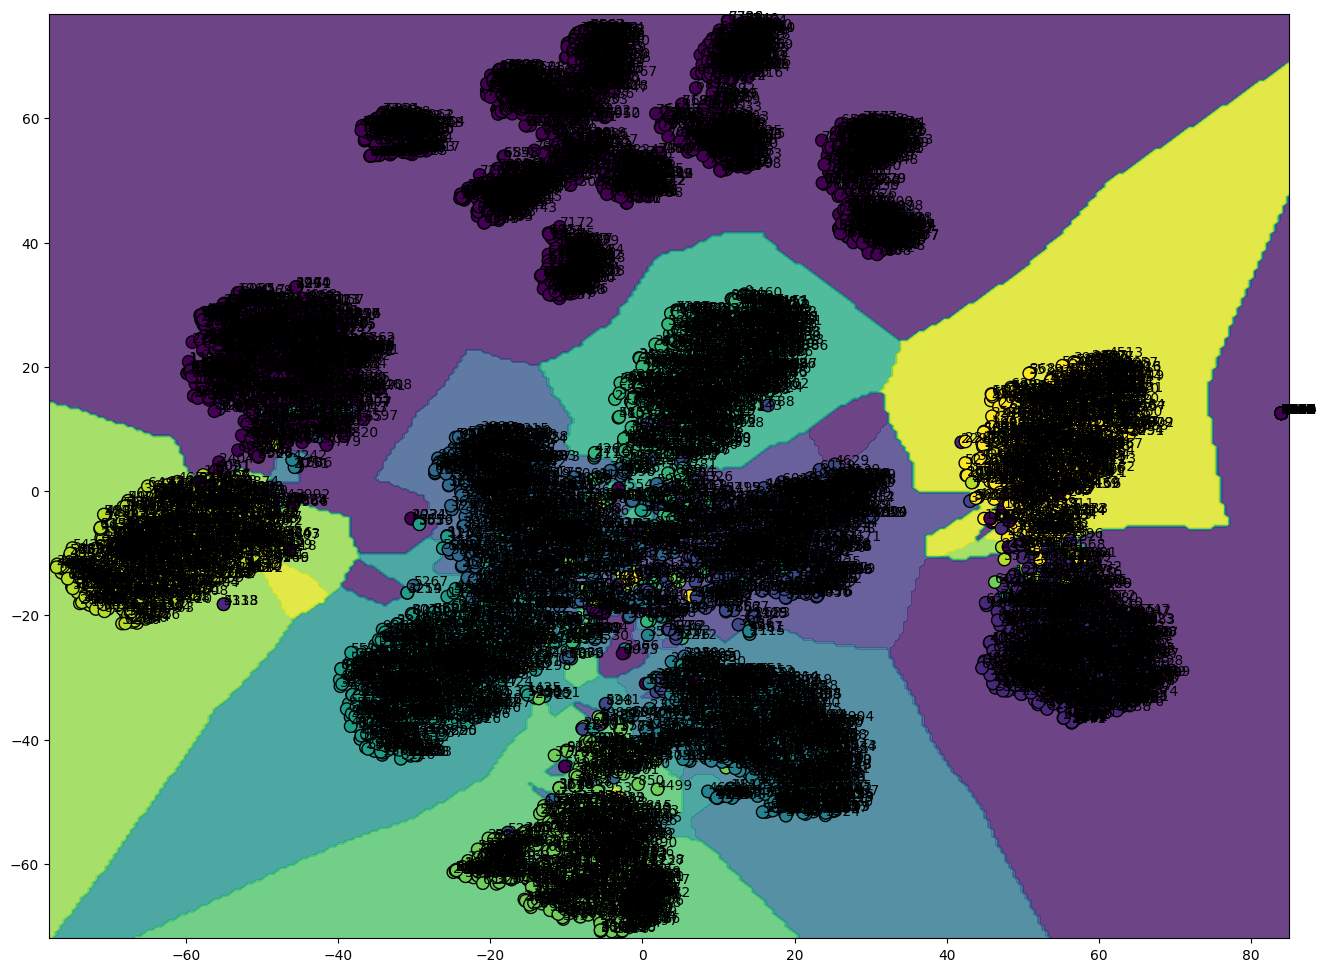

In [68]:
plt.figure(figsize=(16, 12))

x_min, x_max = conv_output_2d[:, 0].min() - 1, conv_output_2d[:, 0].max() + 1
y_min, y_max = conv_output_2d[:, 1].min() - 1, conv_output_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

grid_points_2d = np.c_[xx.ravel(), yy.ravel()]

# For each point in the meshgrid, find the closest point in X_embedded
grid_points_original_indices = np.argmin(np.linalg.norm(conv_output_2d[:, np.newaxis] - grid_points_2d, axis=2), axis=0)

prdict_y = net(images).argmax(1)
# prdict_y = prdict_y.argmax(1)

Z = prdict_y[grid_points_original_indices]
Z = Z.reshape(xx.shape)

grid_points_original = images[grid_points_original_indices]

# Evaluate the decision_function on the approximated original points
#Z = svm_rbf.decision_function(grid_points_original).argmax(1)
#Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=10, c=label, alpha=0.8)


plt.scatter(conv_output_2d[:, 0], conv_output_2d[:, 1], c=label, marker='o', s=80, edgecolors='k')
for i, txt in enumerate(images):
    plt.annotate(str(i), (conv_output_2d[i, 0], conv_output_2d[i, 1]))
plt.savefig('tsne_cifar10_badnet_boud.pdf', format = 'pdf', dpi = 300)